In [1]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# https://www.kaggle.com/datasets/nageshsingh/the-street-view-text-dataset?resource=download

In [2]:
# Load the pretrained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
language_prompts = [
    "This image contains text in English",
    "This image contains text in Spanish",
    "This image contains text in French",
    "This image contains text in Korean",
    "This image contains text in Chinese",
    "This image contains text in Arabic",
]

In [4]:
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    # Preprocess the image for CLIP
    return processor(images=image, return_tensors="pt", padding=True)


In [5]:
def detect_language(image_path, language_prompts):
    inputs = preprocess_image(image_path)

    # Generate image embeddings
    image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

    # Generate text embeddings
    text_inputs = processor(text=language_prompts, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

    # Compute similarity between image and text embeddings
    similarities = (image_features @ text_features.T).squeeze()

    # Identify the most similar language
    best_match_idx = similarities.argmax().item()
    return language_prompts[best_match_idx], similarities[best_match_idx].item()


In [68]:
image_path = "images/chinese.jpg"  # Replace with your image path
detected_language, confidence = detect_language(image_path, language_prompts)
print(f"Detected Language: {detected_language}")
print(f"Confidence: {confidence}")


Detected Language: This image contains text in Chinese
Confidence: 0.24084286391735077


In [69]:
import cv2
import pytesseract

# Specify the path to the tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

def extract_text_regions(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text_regions = pytesseract.image_to_boxes(gray)  # Get bounding boxes
    # Crop text regions and return
    return text_regions

print(extract_text_regions(image_path))

~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 0 0 0 0
~ 0 592 0 768 0
~ 0 590 0 768 0
~ 0 556 0 768 0
~ 0 446 0 768 0
~ 0 425 0 768 0
~ 0 370 0 768 0
~ 0 312 0 626 0
~ 0 241 0 694 0
~ 0 194 0 707 0
I 551 423 553 433 0
| 527 401 532 429 0
a 538 410 539 421 0
e 548 401 560 429 0
s 559 401 567 429 0
F 573 411 574 422 0
o 600 411 609 422 0
1 588 399 628 410 0
— 531 384 572 411 0
f 607 387 610 398 0
f 609 387 610 398 0
a 628 377 638 415 0
n 637 377 645 415 0
a 644 386 667 410 0
e 683 386 741 411 0
- 513 398 522 409 0
~ 0 454 0 768 0
s 425 412 432 438 0
i 431 412 436 438 0
B 444 420 445 433 0
t 457 412 475 438 0
p 345 418 349 421 0
M 359 411 384 421 0
p 387 400 400 428 0
e 399 400 411 428 0
w 419 409 422 421 0
— 439 397 455 410 0
— 477 400 478 405 0
— 382 384 385 395 0
— 401 383 417 408 0
- 417 384 432 396 0
I 458 387 459 391 0
I 494 385 496 394 0
~ 0 192 0 768 0
~ 0 

In [70]:
from pytesseract import Output
import matplotlib.pyplot as plt

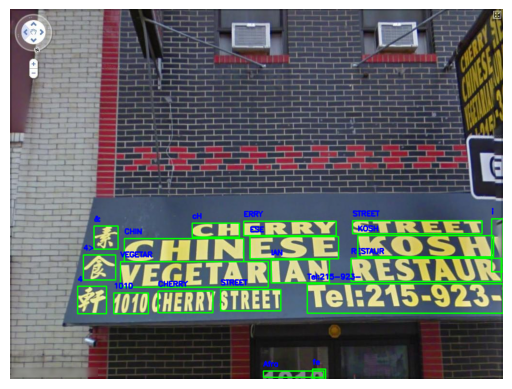

In [71]:
image = cv2.imread(image_path)
data = pytesseract.image_to_data(image, output_type=Output.DICT)

# Loop through each word detected
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 0:  # Filter out weak detections
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        text = data['text'][i]
        if text.strip():  # Ignore empty results
            # Draw a rectangle around each detected word
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Optionally, annotate the image with the detected word
            cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)



# Display the image with bounding boxes inline
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.axis("off")  # Turn off axis
plt.show()

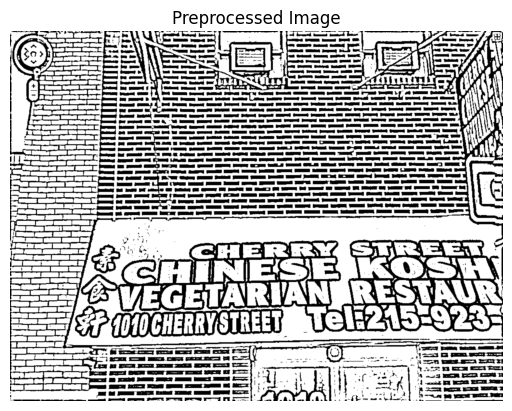

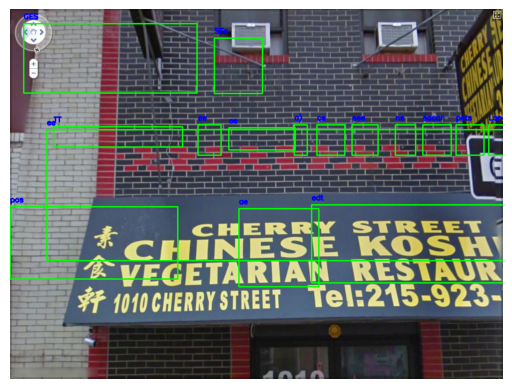

In [72]:
image = cv2.imread(image_path)
# data = pytesseract.image_to_data(image, output_type=Output.DICT)

# Preprocess the image (optional, but can improve accuracy)
new_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

new_image = cv2.GaussianBlur(new_image, (5, 5), 0)
denoised_image = cv2.medianBlur(new_image, 3)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
new_image = cv2.dilate(new_image, kernel, iterations=1)

enhanced_image = cv2.equalizeHist(new_image)

new_image = cv2.adaptiveThreshold(new_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# _, new_image = cv2.threshold(new_image, 127, 255, cv2.THRESH_BINARY)

new_image = cv2.resize(new_image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)




plt.imshow(new_image, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()


# Use Tesseract to get data with bounding boxes
config = r'--psm 6 --oem 3'
# data = pytesseract.image_to_string(scaled_image, output_type=Output.DICT, config=config)
data = pytesseract.image_to_data(new_image, output_type=Output.DICT, config=config)
# data = pytesseract.image_to_data(scaled_image, output_type=Output.DICT)
# data = pytesseract.image_to_boxes(scaled_image, config=config)

# Basic Tesseract OCR call with minimal config
# try:
#     # data = pytesseract.image_to_data(image, output_type=Output.DICT, config='--psm 8 --oem 3')
#     data = pytesseract.image_to_data(image, output_type=Output.DICT, config='words')
#     print("Tesseract successfully executed.")
#     print(data)
# except pytesseract.TesseractError as e:
#     print("TesseractError:", e)

# Loop through each word detected
for i in range(len(data['text'])):
    if int(data['conf'][i]) > 0:  # Filter out weak detections
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        text = data['text'][i]
        if text.strip():  # Ignore empty results
            # Draw a rectangle around each detected word
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Optionally, annotate the image with the detected word
            cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image with bounding boxes inline
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.axis("off")  # Turn off axis
plt.show()


download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar to C:\Users\zelbo/.paddleocr/whl\det\ch\ch_PP-OCRv4_det_infer\ch_PP-OCRv4_det_infer.tar


100%|██████████| 4780/4780 [00:01<00:00, 4035.75it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_rec_infer.tar to C:\Users\zelbo/.paddleocr/whl\rec\ch\ch_PP-OCRv4_rec_infer\ch_PP-OCRv4_rec_infer.tar


100%|██████████| 10720/10720 [00:02<00:00, 4725.41it/s]

[2024/11/25 15:21:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\zelbo/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\zelbo/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

[2024/11/25 15:21:31] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.27022695541381836
[2024/11/25 15:21:31] ppocr DEBUG: cls num  : 7, elapsed : 0.08374428749084473
[2024/11/25 15:21:32] ppocr DEBUG: rec_res num  : 7, elapsed : 0.503021240234375
Bounding Box: [[172.0, 434.0], [239.0, 449.0], [199.0, 641.0], [132.0, 627.0]]
Detected Text: 素食軒
Confidence: 0.85
Bounding Box: [[428.0, 443.0], [669.0, 446.0], [669.0, 476.0], [428.0, 472.0]]
Detected Text: HERRY
Confidence: 1.00
Bounding Box: [[717.0, 441.0], [981.0, 435.0], [982.0, 466.0], [717.0, 471.0]]
Detected Text: STREET
Confidence: 0.99
Bounding Box: [[236.0, 474.0], [681.0, 464.0], [682.0, 516.0], [238.0, 525.0]]
Detected Text: CHNESE
Confidence: 0.99
Bounding Box: [[714.0, 468.0], [1008.0, 470.0], [1008.0, 515.0], [713.0, 513.0]]
Detected Text: KOSH
Confidence: 0.98
Bounding Box: [[228.0, 523.0], [1014.0, 509.0], [1015.0, 565.0], [229.0, 578.0]]
Detected Text: VEGETARIAN RESTAUR
Confidence: 0.96
Bounding Box: [[210.0, 581.0], [1017.0,

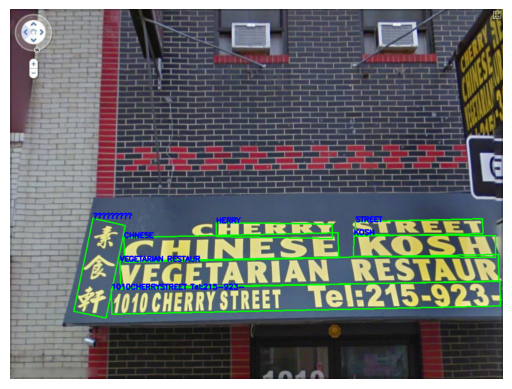

In [ ]:
from paddleocr import PaddleOCR
import numpy as np
import cv2
import matplotlib.pyplot as plt

http://rrc.cvc.uab.es/?ch=15

# http://rrc.cvc.uab.es/?ch=15&com=downloads

image_path = "images/chinese.jpg"

# Initialize OCR
ocr = PaddleOCR(use_angle_cls=True, lang="ch")

# AssertionError: param lang must in dict_keys(['ch', 'en', 'korean', 'japan', 'chinese_cht', 'ta', 'te', 'ka', 'latin', 'arabic', 'cyrillic', 'devanagari']), but got multi

# Perform OCR
results = ocr.ocr(image_path, det=True, rec=True)
# for result in results[0]:
#     print(result[1][0])  # Extracted text
# Print results
for result in results[0]:
    bbox, (text, confidence) = result
    print(f"Bounding Box: {bbox}")
    print(f"Detected Text: {text}")
    print(f"Confidence: {confidence:.2f}")

# Optionally, visualize the bounding boxes using OpenCV
image = cv2.imread(image_path)
for result in results[0]:
    bbox, (text, confidence) = result
    points = [(int(point[0]), int(point[1])) for point in bbox]
    cv2.polylines(image, [np.array(points)], isClosed=True, color=(0, 255, 0), thickness=2)
    cv2.putText(image, text, points[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image with bounding boxes inline
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.axis("off")  # Turn off axis
plt.show()